In [1]:
import pandas as pd
from sklearn import linear_model
import numpy as np

### Observing effects of L2 penalty in polynomial regression ###

In [2]:
# function copyied from previous module

def polynomial_dataframe(feature, degree): 
    """
    Takes an array of 'feature' and a maximal 'degree', 
    and return a data frame with the first column equal to 'feature'
    and the remaining columns equal to ‘feature’ to increasing integer powers up to 'degree'
    :param feature: pandas Series
    :param degree: int >=1
    :return : a dataframe of the feature columns
    """
    poly_dataframe = pd.DataFrame()
    poly_dataframe['power_1'] = feature

    if degree > 1:
        for power in range(2, degree+1):
            name = 'power_' + str(power)
            poly_dataframe[name] = feature.apply(lambda x: x**power)
    return poly_dataframe

In [4]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)
sales = sales.sort_values(['sqft_living','price'])

Create a 15th-order polynomial model fitted with an L2 penalty of 1.5e-5 (Regularization would make the solution numerically stable)

In [17]:
l2_small_penalty = 1.5e-5
poly15_data = polynomial_dataframe(sales['sqft_living'], 15)
model = linear_model.Ridge(alpha=l2_small_penalty, normalize=True)
model.fit(poly15_data, sales['price'])
round(model.coef_[0])

125

Observe Overfitting

In [60]:
set_1 = pd.read_csv('wk3_kc_house_set_1_data.csv', dtype=dtype_dict)
set_2 = pd.read_csv('wk3_kc_house_set_2_data.csv', dtype=dtype_dict)
set_3 = pd.read_csv('wk3_kc_house_set_3_data.csv', dtype=dtype_dict)
set_4 = pd.read_csv('wk3_kc_house_set_4_data.csv', dtype=dtype_dict)
l2_small_penalty=1e-9

In [61]:
def get_ridge_coefficient(df, penalty):
    poly15_data = polynomial_dataframe(df['sqft_living'], 15)
    model = linear_model.Ridge(alpha=penalty, normalize=True)
    model.fit(poly15_data, df['price'])
    print(model.coef_[0])

In [62]:
for df in [set_1, set_2, set_3, set_4]:
    get_ridge_coefficient(df, l2_small_penalty)

544.6693903291846
859.3626475978917
-755.3959047401938
1119.4457483861213


Ridge regression comes to rescue

In [14]:
l2_large_penalty=1.23e2
for df in [set_1, set_2, set_3, set_4]:
    get_ridge_coefficient(df, l2_large_penalty)

2.328068029579326
2.097569027778555
2.289062581189205
2.0859619409193066


Selecting an L2 penalty via cross-validation

In [15]:
train_valid_shuffled = pd.read_csv('wk3_kc_house_train_valid_shuffled.csv', dtype=dtype_dict)
test = pd.read_csv('wk3_kc_house_test_data.csv', dtype=dtype_dict)

In [35]:
def k_fold_cross_validation(k, l2_penalty, data, output):
    """
    :param k: number of validation sets
    :param l2_penalty: 
    :param data: dataframe containing input features
    :param output: column of output values (e.g. price). 
    :return : average validation error
    """
    validation_error = 0
    for i in range(k):
        # Compute starting and ending indices of segment i
        start = round((n*i)/10)
        end = round((n*(i+1))/10)
        
        # Form validation set by taking a slice (start:end+1) from the data
        validation_set = data[start:end+1]
        validation_output = output[start:end+1]
        
        # Form training set by appending slice (end+1:n) to the end of slice (0:start).
        training_set = data[0:start].append(data[end+1:n])
        training_output = output[0:start].append(output[end+1:n])
        
        # Train a linear model using training set just formed, with a given l2_penalty
        model = linear_model.Ridge(alpha=l2_penalty, normalize=True)
        model.fit(training_set, training_output)
        
        # Compute validation error (RSS) using validation set just formed
        rss = sum((model.predict(validation_set) - validation_output)**2)
        
        validation_error += rss
    
    return validation_error/k


 Once we have a function to compute the average validation error for a model, we can write a loop to find the model that minimizes the average validation error. Write a loop that does the following:

- We will again be aiming to fit a 15th-order polynomial model using the sqft_living input
- For each l2_penalty in [10^3, 10^3.5, 10^4, 10^4.5, ..., 10^9] (to get this in Python, you can use this Numpy function: np.logspace(3, 9, num=13).): Run 10-fold cross-validation with l2_penalty.
- Report which L2 penalty produced the lowest average validation error.

Note: since the degree of the polynomial is now fixed to 15, to make things faster, you should generate polynomial features in advance and re-use them throughout the loop. Make sure to use train_valid_shuffled when generating polynomial features!

In [29]:
poly15_data = polynomial_dataframe(train_valid_shuffled['sqft_living'], 15)
penalties = np.logspace(3, 9, num=13)

In [49]:
result = []
for penalty in penalties:
    result.append({"penalty": penalty, "error": k_fold_cross_validation(10, penalty, poly15_data, train_valid_shuffled['price'])})

In [57]:
pd.DataFrame.from_dict(result).sort_values("error").iloc[0]["penalty"]

1000.0

Retrain a final model on all of the training data using this best l2_penalty value that yield smalles validation error. Then use this l2_penalty value to train a model using all training data, and find the RSS on the TEST data.

In [59]:
train_data = pd.read_csv('wk3_kc_house_train_data.csv')
test_data = pd.read_csv('wk3_kc_house_test_data.csv')

poly15_train_data = polynomial_dataframe(train_data['sqft_living'], 15)
model = linear_model.Ridge(alpha=1000, normalize=True)
model.fit(poly15_train_data, train_data['price'])

poly15_test_data = polynomial_dataframe(test_data['sqft_living'], 15)
"{:e}".format(sum((model.predict(poly15_test_data) - test_data['price'])**2))

'2.837569e+14'

### Implementing ridge regression via gradient descent ###

In [63]:
# functions copied from multiple regression module

def get_numpy_data(df, features, output):
    """
    Takes a data set df, a list of features, and a output name, 
    return a 2D array of feature matrix and 1D array of output
    :param df: pandas dataframe of the data set
    :param features: list of the feature names to be selected
    :param output: name of the output
    :return features_matrix: a 2D features_matrix including an additional column of 1s as the constant feature
    :return output_array: a 1D array of output
    """
    # add a constant column
    df['constant'] = 1 
    # prepend variable 'constant' to the features list
    features = ['constant'] + features
    
    # convert the features into a numpy matrix
    features_matrix = df[features].to_numpy()
    # convert the pandas Series into a numpy array
    output_array = df[output].to_numpy()
    output_array = output_array.reshape(output_array.shape[0],1)
    
    return features_matrix, output_array


def predict_outcome(feature_matrix, weights):
    """
    Predict outcome based on the feature matrix and weights given
    :param feature_matrix: 2D matrix of features with a shape of N observations * D features (N*D)
    :param weights: 1D array of weights with D features (D*1)
    :return predictions: 1D array of N predicted outcome (N*1)
    """
    predictions = np.dot(feature_matrix, weights)
    predictions = predictions.reshape(predictions.shape[0],1)
    return predictions


In [292]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    
    # Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. 
    # Therefore the derivative for the weight for feature_i is just two times the dot product between the values 
    # of feature_i and the current errors, plus 2*l2_penalty*w[i].
    
    derivative = 2*np.dot(feature, errors)
    if feature_is_constant == False:
        derivative = derivative + np.array(2*l2_penalty*weight)
    return derivative

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of increase and therefore the negative gradient is the direction of decrease and we're trying to minimize a cost function. 

The amount by which we move in the negative gradient direction is called the ‘step size’. We stop when we are ‘sufficiently close’ to the optimum. Unlike in Module 2, this time we will set a maximum number of iterations and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, write a gradient descent function using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.  The function will take the following parameters:

- 2D feature matrix
- array of output values
- initial weights
- step size
- L2 penalty
- maximum number of iterations


In [288]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
    t = 0  # initiate iterations
    
    while t < max_iterations:
        #while not reached maximum number of iterations:
        # compute the predictions using your predict_output() function
        predictions = predict_outcome(feature_matrix, weights)
        
        # compute the errors as predictions - output
        errors = predictions - output
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            feature_is_constant = True if i == 0 else False
            derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, feature_is_constant)

            # subtract the step size times the derivative from the current weight  
            weights[i] = weights[i] - step_size*derivative
        
        t = t + 1
    return weights


In [275]:
### Single Feature Model with 'sqft_living' ###
simple_features = ['sqft_living']
my_output = 'price'
simple_feature_matrix, output = get_numpy_data(train_data, simple_features, my_output)
simple_test_feature_matrix, test_output = get_numpy_data(test_data, simple_features, my_output)

In [294]:
# No regularization
simple_weights_0_penalty = ridge_regression_gradient_descent(
    simple_feature_matrix, output, np.array([0.,0.]), 1e-12, 0.0, 1000)

# Regularization with L2 penalty at 1e11
simple_weights_high_penalty = ridge_regression_gradient_descent(
    simple_feature_matrix, output, np.array([0.,0.]), 1e-12, 1e11, 1000)

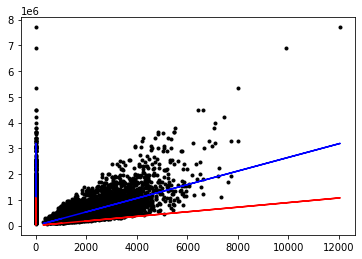

In [290]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
        simple_feature_matrix,predict_outcome(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_outcome(simple_feature_matrix, simple_weights_high_penalty),'r-')

In [285]:
### Model with two features ###
model_features = ['sqft_living', 'sqft_living15']
my_output = 'price'
feature_matrix, output = get_numpy_data(train_data, model_features, my_output)
test_feature_matrix, test_output = get_numpy_data(test_data, model_features, my_output)

In [286]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(
    feature_matrix, output, np.array([0.,0.,0.]), 1e-12, 0, 1000)
multiple_weights_high_penalty = ridge_regression_gradient_descent(
    feature_matrix, output, np.array([0.,0.,0.]), 1e-12, 1e11, 1000)